In [76]:

import copy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from numba import float32, float64, jit, NumbaPerformanceWarning
import warnings
import os
import yaml

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["mathtext.fontset"] = "cm"
# plt.rcParams['axes.labelsize']=14
# plt.rcParams['xtick.labelsize']=11
# plt.rcParams['ytick.labelsize']=11
# plt.rcParams['axes.grid']=True
# plt.rcParams['axes.xmargin']=0

In [77]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_onestep import GPTConfig, GPT
import tqdm
import argparse

In [78]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [79]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [80]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [81]:
torch.cuda.is_available()

True

In [82]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_onestep_lin.pt", map_location=device)

In [83]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [84]:
# del exp_data["model_args"]['use_pi']

In [85]:
model_args = exp_data["model_args"]
# model_args['use_p'] = True
# model_args['use_i'] = True
# model_args['use_d'] = False
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 0.11M


In [86]:
from control_torch import drss, set_seed, forced_response, tf2ss, c2d
set_seed(42)

seq_len = 300
nx = 2
nu = 1
ny = 1

# define settings
ts = 1e-2

# define nominal model
G = drss(nx, nu, ny, device=device)

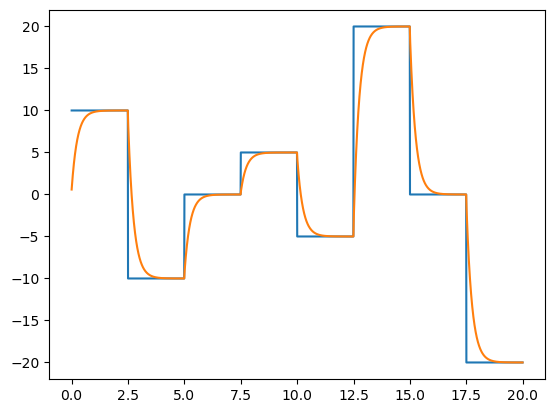

In [87]:
T = 20
t = torch.arange(0, T, ts, device=device, dtype=torch.float32).view(-1, 1)
r = torch.ones_like(t, device=device, dtype=torch.float32)
# r[t_CL < 1] = -5
# r[(t_CL >= 1) & (t_CL < 2)] = 5
# r[(t_CL >= 2) & (t_CL < 3)] = 0
r[(t < 2.5)] = 10
r[(t >= 2.5) & (t < 5)] = -10
r[(t >= 5.0) & (t < 7.5)] = 0
r[(t >= 7.5) & (t < 10)] = 5
r[(t >= 10.) & (t < 12.5)] = -5
r[(t >= 12.5) & (t < 15.)] = 20
r[(t >= 15.0) & (t < 17.5)] = 0
r[(t >= 17.5) & (t < 20.0)] = -20

tau = 1
M_num = torch.tensor([0.01, 1], device=device, dtype=torch.float32)  # Numerator coefficients
M_den = torch.tensor([tau/4, 1], device=device, dtype=torch.float32)  # Denominator coefficients
M = tf2ss(M_num, M_den, device=device)
M_d = c2d(*M, ts, device=device)
y_d = forced_response(*M_d, r)

plt.plot(t.cpu().numpy(), r.cpu().numpy())
plt.plot(t.cpu().numpy(), y_d.cpu().numpy())

In [88]:
print(model.proportional_coefficient)
print(model.integral_coefficient)
print(model.derivative_coefficient)

Parameter containing:
tensor([0.7413], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.0114], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.7334], device='cuda:0', requires_grad=True)


In [89]:
H = 100

E = torch.empty_like(t, device=device, dtype=torch.float32).reshape(1,-1,1)
U = torch.empty(t.size(0)+1, device=device, dtype=torch.float32).reshape(1,-1,1)
Y = torch.empty_like(t, device=device, dtype=torch.float32).reshape(1,-1,1)

with torch.no_grad():
    # initial
    U[0,0,0] = 0
    y_i = 0
    x_i = torch.zeros(nx, device=device, dtype=torch.float32)
    
    for i in range(len(t)):
        
        print('time instant:', i)
        # start the loop with error
        e_i = r[i] - y_i
            
        Y[0,i,0] = y_i
        E[0,i,0] = e_i
        
        # Controller u(t) = C(e(t),u(t-1))
        if i < H:
            pred = model(E[:, :i+1, :] / 200, U[:, :i+1, :] / 200)
        else:
            pred = model(E[:, i-H+1:i+1, :] / 200, U[:, i-H+1:i+1, :] / 200)
            
        U[0,i+1,0] = pred[0,-1,0] * 200 # just for coherence, it could be directly be u_i_prev
        
        y, x_i = forced_response(*G, U[0,i:i+2,:], return_x=True, x0=x_i)
        
        y_i = y[-1]

time instant: 0
time instant: 1
time instant: 2
time instant: 3
time instant: 4
time instant: 5
time instant: 6
time instant: 7
time instant: 8
time instant: 9
time instant: 10
time instant: 11
time instant: 12
time instant: 13
time instant: 14
time instant: 15
time instant: 16
time instant: 17
time instant: 18
time instant: 19
time instant: 20
time instant: 21
time instant: 22
time instant: 23
time instant: 24
time instant: 25
time instant: 26
time instant: 27
time instant: 28
time instant: 29
time instant: 30
time instant: 31
time instant: 32
time instant: 33
time instant: 34
time instant: 35
time instant: 36
time instant: 37
time instant: 38
time instant: 39
time instant: 40
time instant: 41
time instant: 42
time instant: 43
time instant: 44
time instant: 45
time instant: 46
time instant: 47
time instant: 48
time instant: 49
time instant: 50
time instant: 51
time instant: 52
time instant: 53
time instant: 54
time instant: 55
time instant: 56
time instant: 57
time instant: 58
time in

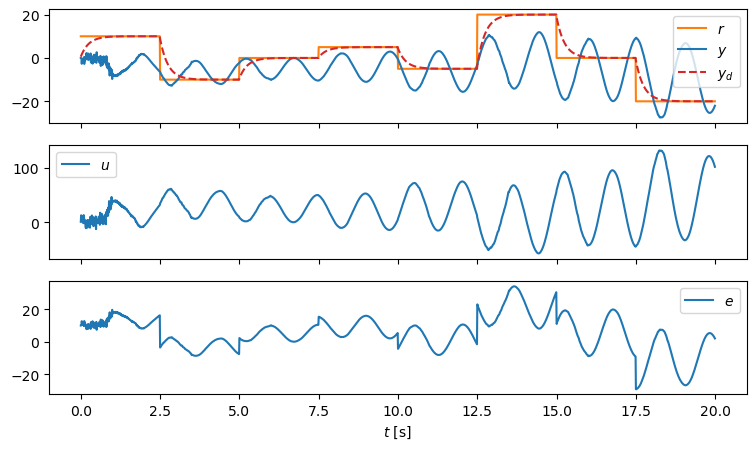

In [90]:
fig = plt.figure(figsize=(9, 5))
ax1 = plt.subplot(311)
#plt.plot(t_CL, r)
plt.plot(t.cpu().numpy(), r.cpu().numpy(), label="$r$", c='tab:orange')
plt.plot(t.cpu().numpy(), Y[0,:,0].cpu().numpy(), label="$y$", c='tab:blue', alpha=1)
plt.plot(t.cpu().numpy(), y_d.cpu().numpy(), label="$y_d$", c='tab:red', alpha=1, linestyle='--')
plt.legend(['$r$','$y$','$y_d$'])
# plt.xlim([0, 0.43])
# plt.ylim([0, 10])
plt.tick_params('x', labelbottom=False)

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(t.cpu().numpy(), U[0,1:,0].cpu().numpy(), c='tab:blue', alpha=1)
# plt.plot(t_CL[:-1], batch_u[0,1:,0] * u_std, c='tab:green', alpha=1)
plt.legend(['$u$', '$u_{ideal}$'])
# plt.xlim([10, 12])
plt.tick_params('x', labelbottom=False)

ax3 = plt.subplot(313, sharex=ax1)
plt.plot(t.cpu().numpy(), E[0,:,0].cpu().numpy(), c='tab:blue', alpha=1)
# plt.plot(t_CL, batch_e[0,:,0] * e_std, c='tab:green', alpha=1)
plt.xlabel('$t$ [s]')
# plt.ylim([0, 4])
plt.legend(['$e$', '$e_{ideal}$'])

# plt.savefig('transformer_controller.pdf')

plt.show()